In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db=mysql.connector.connect(host='localhost',username='root',password='12345',database='ecommerce')

cur=db.cursor()


# List all unique cities where customers are located.

In [26]:
query="""select distinct customer_city from customers"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data)
df.head(5)

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [5]:
query="""select count(order_id) from orders where year(order_purchase_timestamp) =2017"""

cur.execute(query)
data=cur.fetchall()

"total orders placed in 2017 are ",data[0][0]

('total orders placed in 2017 are ', 45101)

# Find the total sales per category.

In [12]:
query="""
select upper(pr.product_category),round(sum(payment_value),2) as total_sales from products as pr
inner join order_items as oi on pr.product_id=oi.product_id
inner join payments as p on oi.order_id=p.order_id
group by pr.product_category"""

cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data,columns=["category","sales"])
df

,category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,FASHION BAGS AND ACCESSORIES,218158.28
4,BED TABLE BATH,1712553.67
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in installments.

In [15]:
query="""select (sum(case when payment_installments>=1 then 1 else 0 end)/count(*))*100
from payments"""

cur.execute(query)
data=cur.fetchall()
"the percentage of orders that were paid in installments",data[0][0]

('the percentage of orders that were paid in installments', Decimal('99.9981'))

# Count the number of customers from each state. 

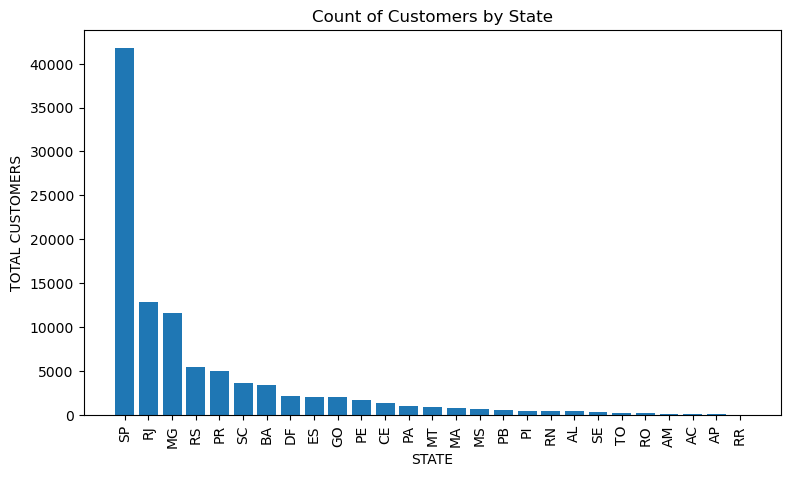

In [34]:
query="""select customer_state,count(customer_Id)as total_customers
from customers
group by customer_state"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["STATE","TOTAL_CUSTOMERS"])
df=df.sort_values(by="TOTAL_CUSTOMERS",ascending=False)

plt.figure(figsize=(9,5))
plt.bar(df["STATE"],df['TOTAL_CUSTOMERS'])
plt.title("Count of Customers by State")
plt.xlabel('STATE')
plt.ylabel('TOTAL CUSTOMERS')
plt.xticks(rotation=90)
plt.show()

# Calculate the number of orders per month in 2018.

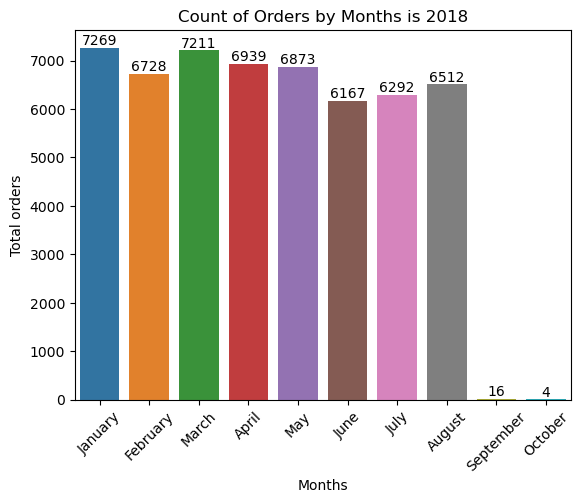

In [31]:
query="""select monthname(order_purchase_timestamp) as month_,count(order_id) as total_orders
from orders
where year(order_purchase_timestamp)=2018
group by monthname(order_purchase_timestamp)
order by total_orders desc"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Months","Total orders"])
o=["January" ,"February" ,"March","April" ,"May" ,"June" ,"July","August","September","October"]
ax=sns.barplot(x="Months",y="Total orders",data=df,order=o)
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")
plt.show()

# Find the average number of products per order, grouped by customer city.

In [42]:
query ="""select customer_city,avg(order_count) as avg_no_of_products from( select oi.order_id ,c.customer_city,count(oi.product_id)as order_count from  order_items as oi 
inner join orders as o on oi.order_id=o.order_id
inner join customers as c on o.customer_id=c.customer_id
group by oi.order_id ,c.customer_city)as subquery
group by customer_city order by avg(order_count) desc"""

cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=['Customer city','AVG Products/orders'])
df.head(10)

,Customer city,AVG Products/orders
0,padre carvalho,7.0000
1,celso ramos,6.5000
2,datas,6.0000
3,candido godoi,6.0000
4,matias olimpio,5.0000
5,cidelandia,4.0000
6,picarra,4.0000
7,curralinho,4.0000
8,teixeira soares,4.0000
9,morro de sao paulo,4.0000


# Calculate the percentage of total revenue contributed by each product category.

In [48]:
query="""WITH CategoryRevenue AS (
    SELECT pr.product_category,
           ROUND(SUM(p.payment_value),2) AS category_revenue
    FROM products AS pr
    INNER JOIN order_items AS oi ON pr.product_id = oi.product_id
    INNER JOIN payments AS p ON oi.order_id = p.order_id
    GROUP BY pr.product_category
),
TotalRevenue AS (
    SELECT SUM(category_revenue) AS total_revenue
    FROM CategoryRevenue
)
SELECT UPPER(cr.product_category),
       cr.category_revenue,
       ROUND((cr.category_revenue / tr.total_revenue) * 100,2) AS percentage
FROM CategoryRevenue cr
CROSS JOIN TotalRevenue tr
ORDER BY percentage DESC
"""
cur.execute(query)
data=cur.fetchall()
data
df =pd.DataFrame(data,columns=['PRODUCT CATEGORY','CATEGORY REVENUE','PERCENTAGE'])
df.head(10)

,PRODUCT CATEGORY,CATEGORY REVENUE,PERCENTAGE
0,BED TABLE BATH,1712553.67,8.43
1,HEALTH BEAUTY,1657373.12,8.16
2,COMPUTER ACCESSORIES,1585330.45,7.81
3,FURNITURE DECORATION,1430176.39,7.04
4,WATCHES PRESENT,1429216.68,7.04
5,SPORT LEISURE,1392127.56,6.86
6,HOUSEWARES,1094758.13,5.39
7,AUTOMOTIVE,852294.33,4.20
8,GARDEN TOOLS,838280.75,4.13
9,COOL STUFF,779698.00,3.84


# Identify the correlation between product price and the number of times a product has been purchased. 

In [57]:
query="""select p.product_category,round(avg(oi.price),2) as avg_price, count(oi.product_id)
from order_items as oi
inner join products as p
on oi.product_id=p.product_id
group by p.product_category
order by count(oi.product_id) desc"""

cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=['PRODUCT CATEGORY','AVG PRICE','ORDER COUNT'])
df

arr1=df['AVG PRICE']
arr2=df['ORDER COUNT']

a=np.corrcoef([arr1,arr2])
print('the correlation between product price and the number of times a product has been purchased is',a[0][1])

the correlation between product price and the number of times a product has been purchased is -0.10631514167157564


# Calculate the total revenue generated by each seller, and rank them by revenue.

In [60]:
query="""select s.seller_id,Sum(p.payment_value)as total_revenue,rank() over (order by Sum(p.payment_value) desc) as Rank_no
from sellers as s
inner join order_items as oi 
on s.seller_id=oi.seller_id
inner join payments as p 
on oi.order_id=p.order_id
group by s.seller_id"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Seller ID','Total Revenue','Rank'])
df.head(10)

,Seller ID,Total Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2
2,4a3ca9315b744ce9f8e9374361493884,301245.269765,3
3,1f50f920176fa81dab994f9023523100,290253.420128,4
4,53243585a1d6dc2643021fd1853d8905,284903.080498,5
5,da8622b14eb17ae2831f4ac5b9dab84a,272219.319315,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,264166.120939,7
7,955fee9216a65b617aa5c0531780ce60,236322.300502,8
8,fa1c13f2614d7b5c4749cbc52fecda94,206513.229870,9
9,7e93a43ef30c4f03f38b393420bc753a,185134.209706,10


# Calculate the moving average of order values for each customer over their order history.

In [61]:
query="""select c.customer_id ,o.order_purchase_timestamp,
avg(payment_value)over (partition by c.customer_id order by o.order_purchase_timestamp rows between 2 preceding and current row) as moving_avg 
from payments as p
inner join orders as o on p.order_id=o.order_id
inner join customers as c on o.customer_id=c.customer_id"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['CustomerID','Order_Purchase_Timestamp','Moving Avg'])
df

,CustomerID,Order_Purchase_Timestamp,Moving Avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.010002
...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.500000


#  Calculate the cumulative sales per month for each year.

In [65]:
query="""select year_,month_,round(sales,2),round(sum(sales)over (order by year_,month_ ),2)as cumulative_sales from(
select year(order_purchase_timestamp)as year_,monthname(o.order_purchase_timestamp)as month_,sum(p.payment_value) as sales
from orders as o
inner join payments as p 
on o.order_id=p.order_id
group by year_,month_
order by year_,month_)as p"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['YEAR','MONTH','SALES','CUMULATIVE SALES'])
df

,YEAR,MONTH,SALES,CUMULATIVE SALES
0,2016,December,19.62,19.62
1,2016,October,59090.48,59110.10
2,2016,September,252.24,59362.34
3,2017,April,417788.03,477150.37
4,2017,August,674396.32,1151546.69
5,2017,December,878401.48,2029948.17
6,2017,February,291908.01,2321856.18
7,2017,January,138488.04,2460344.22
8,2017,July,592382.92,3052727.14
9,2017,June,511276.38,3564003.52


# Calculate the year-over-year growth rate of total sales.

In [66]:
query="""select year_,Total_sales, ((Total_sales - lag(Total_sales, 1) over(order by year_))/
lag(Total_sales, 1) over(order by year_)) * 100 AS yoy_growth
from (
select year(o.order_purchase_timestamp)as year_,ROUND(Sum(p.payment_value),2) as Total_sales from orders as o
inner join payments as p
on o.order_id=p.order_id
group by year_)as a"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Year','Total Sales','YOY Growth %'])
df

,Year,Total Sales,YOY Growth %
0,2016,59362.34,NaN
1,2017,7249746.73,12112.703761
2,2018,8699763.05,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [67]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

#  Identify the top 3 customers who spent the most money in each year.

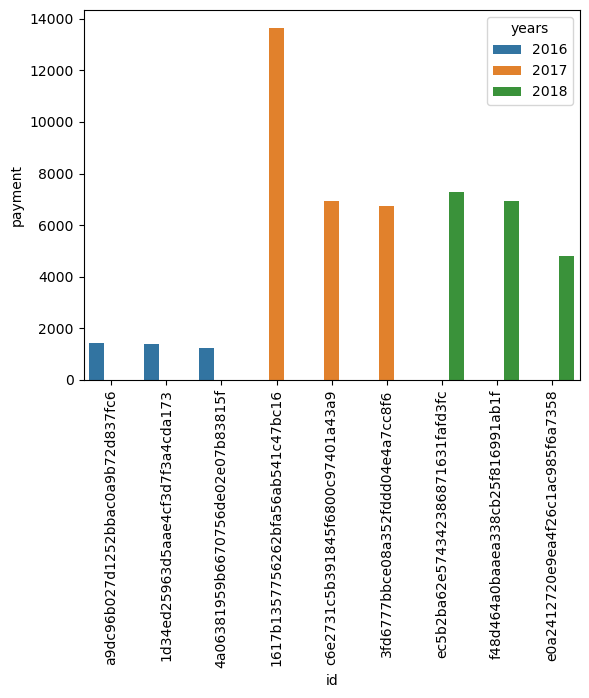

In [68]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()